In [1]:
import ast
import re
import os
import pandas as pd
import numpy as np
from typing import TypedDict, List, Dict, Optional
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
import openpyxl
from openpyxl.formula.tokenizer import Tokenizer
from openpyxl.utils import get_column_letter, coordinate_to_tuple, column_index_from_string
from IPython.display import Image, display

from dotenv import load_dotenv
load_dotenv()
llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [2]:
def get_dependencies_from_tokens(formula, current_sheet, all_headers_map):
    """
    Uses the official Excel formula tokenizer to find sheet and cell references.
    """
    tok = Tokenizer(formula)
    dependencies = []

    for token in tok.items:
        # We only care about OPERAND tokens (cells, ranges, sheet refs)
        if token.type == "OPERAND":
            value = token.value
            sheet_name = current_sheet
            
            # 1. Check if there is a sheet reference (e.g., Sales!D2)
            if "!" in value:
                sheet_part, cell_part = value.split("!")
                sheet_name = sheet_part.strip("'")
                value = cell_part
            
            # 2. Extract column letters from the cell/range (e.g., D2:D10 -> D)
            # Find all sequences of letters that look like column IDs
            col_matches = re.findall(r'[A-Z]+', value)
            
            for col_letter in col_matches:
                try:
                    col_idx = column_index_from_string(col_letter)
                    if sheet_name in all_headers_map and col_idx in all_headers_map[sheet_name]:
                        header = all_headers_map[sheet_name][col_idx]
                        dependencies.append(f"{sheet_name}.{header}")
                except ValueError:
                    continue # Not a valid column letter

    return list(set(dependencies))

def get_all_sheet_headers(wb):
    all_headers = {}
    for sheet_name in wb.sheetnames:
        ws = wb[sheet_name]
        all_headers[sheet_name] = {
            c: ws.cell(row=1, column=c).value 
            for c in range(1, ws.max_column + 1) 
            if ws.cell(row=1, column=c).value
        }
    return all_headers

def extract_metadata_final(file_path):
    wb = openpyxl.load_workbook(file_path, data_only=False)
    # Peek at types only
    wb_types = openpyxl.load_workbook(file_path, data_only=True)
    
    all_headers = get_all_sheet_headers(wb)
    metadata = {}

    for sheet_name in wb.sheetnames:
        ws = wb[sheet_name]
        ws_types = wb_types[sheet_name]
        sheet_formulas = []
        
        # Track formula headers to filter them out of raw inputs later
        formula_header_names = []

        for col_idx, header in all_headers[sheet_name].items():
            cell = ws.cell(row=2, column=col_idx)
            # Get evaluated value to determine data type
            type_val = ws_types.cell(row=2, column=col_idx).value
            
            if cell.data_type == 'f':
                formula = cell.value
                formula_header_names.append(header)
                
                deps = get_dependencies_from_tokens(formula, sheet_name, all_headers)
                deps = [d for d in deps if d != f"{sheet_name}.{header}"]

                sheet_formulas.append({
                    "column": header,
                    "formula": formula,
                    "dtype": type(type_val).__name__ if type_val is not None else "Unknown",
                    "depends_on": deps,
                    "method_name": f"calculate_{str(header).lower().replace(' ', '_')}"
                })

        # --- UPDATED RAW INPUTS LOGIC ---
        raw_inputs_with_types = []
        for col_idx, header in all_headers[sheet_name].items():
            if header not in formula_header_names:
                # Get type for raw data columns too
                raw_val = ws_types.cell(row=2, column=col_idx).value
                raw_inputs_with_types.append({
                    "column": header,
                    "dtype": type(raw_val).__name__ if raw_val is not None else "Unknown"
                })

        metadata[sheet_name] = {
            "formulas": sheet_formulas,
            "raw_inputs": raw_inputs_with_types
        }

    return metadata


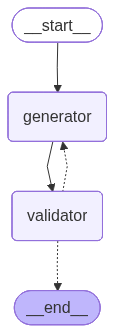

In [10]:
class AgentState(TypedDict):
    metadata: Dict           
    file_path: str           
    test_file_path: str      
    full_code: str           
    error_log: Optional[str] 
    iterations: int          
    success: bool

def generator_node(state: AgentState):
    metadata = state["metadata"]
    # If there is an error log, we emphasize it as a FIX request
    context_instruction = (
        "This is the initial generation. Please create the full class." 
        if not state['error_log'] else 
        f"LOGICAL ERRORS FOUND IN PREVIOUS ATTEMPT:\n{state['error_log']}\n"
        "Please surgically fix ONLY the broken formulas while keeping the rest of the structure intact."
    )

    prompt = f"""
    You are a Senior Data Engineer. Convert Excel metadata into a COMPLETE Python script.
    
    METADATA: {metadata}
    CONTEXT: {context_instruction}

    STRICT REQUIREMENTS:
    1. Output the FULL script every time (Imports, Class, Methods, Transform).
    2. Define `class ExcelModel:`
    3. The `__init__` method MUST NOT take any arguments except `self`. 
       Example: `def __init__(self): pass`
    4. Every formula method must have a docstring listing its Excel formula and dependencies.
    5. Use vectorized Pandas/Numpy logic.
    6. The `transform` method MUST take `all_sheets_dict` (a dictionary of DataFrames).
       Example: `def transform(self, all_sheets_dict):`
    7. Inside `transform`, extract sheets as needed: `sales_df = all_sheets_dict['Sales']`.
    8. The 'transform' method must execute methods in the correct dependency order.
    9. Return ONLY the code block.
    10. If a sheet exists in the metadata but is not provided in all_sheets_dict (because it is entirely derived), 
        you MUST initialize it inside the transform method as a new DataFrame.
    """
    
    response = llm.invoke(prompt)
    
    code_match = re.search(r"```python\s+(.*?)\s+```", response.content, re.DOTALL)
    if code_match:
        code = code_match.group(1)
    else:
        code = response.content
    return {"full_code": code}

def logical_validator_node(state: AgentState):
    code = state["full_code"]
    test_file = state["test_file_path"]
    metadata = state["metadata"]
    
    # 1. Syntax & Execution Test
    try:
        exec_globals = {"pd": pd, "np": np}
        exec(code, exec_globals)
        ExcelModel = exec_globals['ExcelModel']
        model = ExcelModel()
    except Exception as e:
        return {"success": False, "error_log": f"Execution/Syntax Error: {str(e)}", "iterations": state["iterations"] + 1}

    error_messages = []
    print(f"\n--- 🧪 Testing Iteration {state['iterations'] + 1} ---")
    # print(metadata.keys())
    
    try:
        all_sheets_actual = {sheet: pd.read_excel(test_file, sheet_name=sheet) for sheet in metadata.keys()}
        results_python = model.transform(all_sheets_actual.copy())

        for sheet_name, meta in metadata.items():
            for formula_item in meta['formulas']:
                col_name = formula_item['column']
                
                actual = all_sheets_actual[sheet_name][col_name]
                predicted = results_python[sheet_name][col_name]

                try:
                    # atol=1e-2 allows for minor floating point differences
                    pd.testing.assert_series_equal(actual, predicted, atol=1e-2, check_dtype=False)
                    print(f"✅ PASS: {sheet_name} -> {col_name}")
                except AssertionError:
                    
                    # We create a comparison dataframe of the first few mismatches
                    diff_df = pd.DataFrame({
                        "Excel_Actual": actual,
                        "Python_Calculated": predicted
                    })
                    # Identify where they are not equal (respecting the tolerance)
                    mismatches = diff_df[~(np.isclose(diff_df['Excel_Actual'], diff_df['Python_Calculated'], atol=1e-2))]
                    
                    # Capture the top 5 mismatches to show the LLM
                    sample_mismatch = mismatches.head(5).to_string()
                    
                    msg = (
                        f"❌ FAIL: {col_name} in {sheet_name}\n"
                        f"Formula: {formula_item['formula']}\n"
                        f"Sample Mismatches:\n{sample_mismatch}\n"
                    )
                    print(msg)
                    error_messages.append(msg)

        if not error_messages:
            return {"success": True, "error_log": None}
        else:
            return {
                "success": False, 
                "error_log": "\n".join(error_messages), 
                "iterations": state["iterations"] + 1
            }

    except Exception as e:
        return {"success": False, "error_log": f"Runtime Error: {str(e)}", "iterations": state["iterations"]+1}
    
def route_after_validation(state: AgentState):
    # If the logic passed OR we hit our 5-try ceiling, exit
    if state["success"] or state["iterations"] >= 3:
        return END
    
    # Otherwise, tell the graph to go back to the 'generator'
    print(f"🔄 Retrying... Iteration {state['iterations']}")
    return "generator"

builder = StateGraph(AgentState)
builder.add_node("generator", generator_node)
builder.add_node("validator", logical_validator_node)

builder.add_edge(START, "generator")
builder.add_edge("generator", "validator")
builder.add_conditional_edges(
    "validator", 
    route_after_validation, 
    {
        "generator": "generator", # Map return value 'generator' to generator node
        END: END                   # Map return value END to end node
    }
)

app = builder.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [11]:
if __name__ == "__main__":
    # Configure paths
    TEMPLATE = "complex_financial_model_4.xlsx"
    TEST_DATA = "test_financial_model_4.xlsx"
    FINAL_PY = "test_financial_model_4_0.py"

    # Extract metadata using your refined extractor
    meta = extract_metadata_final(TEMPLATE)

    print("🚀 Starting Autonomous Conversion...")
    final_output = app.invoke({
        "metadata": meta,
        "file_path": TEMPLATE,
        "test_file_path": TEST_DATA,
        "full_code": "",
        "iterations": 0,
        "success": False,
        "error_log": None
    })

    # Save the 'Best Effort' or 'Verified' code
    if final_output["full_code"]:
        with open(FINAL_PY, "w", encoding="utf-8") as f:
            f.write(final_output["full_code"])
        
        print("\n" + "="*50)
        if final_output["success"]:
            print(f"🏆 SUCCESS: Model is 100% verified against {TEST_DATA}")
        else:
            print(f"⚠️ PARTIAL SUCCESS: Saved best effort after 5 attempts.")
            print("Remaining Issues to check manually:")
            print(final_output["error_log"])
        print(f"File: {os.path.abspath(FINAL_PY)}")
        print("="*50)

    # --- NEW: SAVE THE TEST LOG ---
    with open("pytest_validation_log_4_0.txt", "w") as log_file:
        if final_output["success"]:
            log_file.write("ALL TESTS PASSED SUCCESSFULLY.\n")
        else:
            log_file.write("TESTING COMPLETED WITH ERRORS:\n")
            log_file.write(final_output.get("error_log", "No error log captured."))
    
    print("📋 Test log saved to pytest_validation_log_4_0.txt")

🚀 Starting Autonomous Conversion...

--- 🧪 Testing Iteration 1 ---
🔄 Retrying... Iteration 1

--- 🧪 Testing Iteration 2 ---
🔄 Retrying... Iteration 2

--- 🧪 Testing Iteration 3 ---
✅ PASS: Sales -> Price_Adjusted
✅ PASS: Financials -> Total_Sales
✅ PASS: Financials -> Global_Margins_Value
✅ PASS: Financials -> Profit_Loss

🏆 SUCCESS: Model is 100% verified against test_financial_model_4.xlsx
File: c:\Users\arind\Documents\GitHub\LangGraph\LangGraph\test_financial_model_4_0.py
📋 Test log saved to pytest_validation_log_4_0.txt
